In [1]:
from pathlib import Path
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tex_fonts = {
    
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
   "axes.labelsize": 12,
   "font.size": 12,

   "legend.fontsize": 10,
   "xtick.labelsize": 10,
   "ytick.labelsize": 10
}

In [3]:
plt.rcParams.update(tex_fonts) # use latex fonts
#plt.rcParams.update({"axes.grid": True}) 

In [4]:
out = Path("out")

fig_dir = Path("fig")
fig_dir.mkdir(exist_ok=True)

In [5]:
ckpt_red_20 = pickle.load(open(out / "mc_red.p", "rb"))
df_red_20 = pd.DataFrame(ckpt_red_20["fit"].T, columns=[str(l) for l in ckpt_red_20["train_lens"]])
df_red_20 = df_red_20.melt(var_name="length", value_name="fit")
df_red_20.insert(0, "model", "reduced 20")

In [6]:
ckpt_red_10 = pickle.load(open(out / "mc_red_10.p", "rb"))
df_red_10 = pd.DataFrame(ckpt_red_10["fit"].T, columns=[str(l) for l in ckpt_red_10["train_lens"]])
df_red_10 = df_red_10.melt(var_name="length", value_name="fit")
df_red_10.insert(0, "model", "reduced 10")

In [7]:
ckpt_full = pickle.load(open(out / "mc_full.p", "rb"))

df_full = pd.DataFrame(ckpt_full["fit_bfgs"].T, columns=[str(l) for l in ckpt_full["train_lens"]])
df_full = df_full.melt(var_name="length", value_name="fit")
df_full.insert(0, "model", "full")

In [8]:
df_mc = pd.concat((df_red_20, df_red_10, df_full), ignore_index=True)

In [9]:
rms_y = 66.69 # 1e5 rmse of y 
fit_lin = 77.17 # fit of a linear baseline obtained with MATLAB's sysid toolbox
rmse_lin = (1 - fit_lin/100.0) * rms_y # rmse of a linear baseline
rmse_lin/1e5

0.00015225326999999996

In [10]:
df_mc["fit"] = np.maximum(df_mc["fit"], 0.0)
df_mc["rmse"] = (1 - df_mc["fit"]/100.0) * rms_y

In [11]:
df_mc = df_mc[df_mc["length"].isin(["100", "200", "400", "500", "600", "800", "1000", "2000", "3000", "4000", "5000"])]
df_mc["length"] = df_mc["length"].astype(int)
df_mc.sort_values(by=["model", "length"], inplace=True)

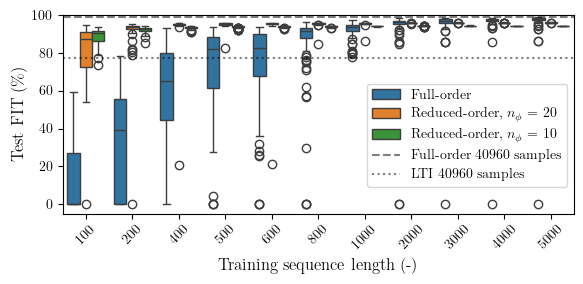

In [12]:
model_labels = {
    "full": r"Full-order",
    "reduced 20": r"Reduced-order, $n_\phi$ = 20",
    "reduced 10": r"Reduced-order, $n_\phi$ = 10",
}
model_order = ["full", "reduced"]

linewidth = 251.8068
#fig, ax = plt.subplots(1, 1, figsize=(8, 4))
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax = sns.boxplot(df_mc, x="length", y="fit", hue=df_mc["model"].map(model_labels), hue_order=model_labels.values(), ax=ax)
#ax = sns.boxplot(df_mc, x="length", y="fit", hue=df_mc["model"], hue_order=["full", "reduced 20", "reduced 10"])
ax.axhline(y=98.9, color="black", linestyle="dashed", alpha=0.5, label="Full-order 40960 samples")#, linewidth=0.5)
ax.axhline(y=fit_lin, color="black", linestyle="dotted", alpha=0.5, label="LTI 40960 samples")#, linewidth=0.5)

plt.tight_layout()  # This adjusts the plot to ensure the legend fits
plt.xticks(rotation=45)
ax.set_xlabel(r"Training sequence length (-)")
ax.set_ylabel(r"Test FIT (\%)")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.1))#, borderaxespad=0)
plt.ylim([-5, 100])
plt.tight_layout()

plt.savefig(fig_dir/"boxplot_paper.pdf")

In [13]:
df_stats = df_mc.groupby(["model", "length"]).agg(["mean", "median", "std"])
df_stats

fit                             rmse             \
                        mean     median        std       mean     median   
model      length                                                          
full       100     13.759863   0.000000  19.206714  57.513547  66.690000   
           200     32.464637  39.153266  25.087060  45.039334  40.578687   
           400     58.577586  64.950041  27.463071  27.624608  23.374818   
           500     70.436656  81.974467  24.522164  19.715794  12.021228   
           600     72.843189  82.636819  23.548835  18.110877  11.579506   
           800     85.760602  91.416369  18.288373   9.496255   5.724424   
           1000    92.276627  93.544232   4.026392   5.150718   4.305351   
           2000    93.612466  95.956506  13.720642   4.259846   2.696606   
           3000    95.229760  96.808146   9.999166   3.181273   2.128647   
           4000    96.056245  97.408774   9.978938   2.630090   1.728089   
           5000    96.277672  97.770873  10.016155   2.482420   1.486605   
reduced 10 100     88.610156  90.157748   4.065830   7.595887   6.563798   
           200     92.086803  92.402100   1.373189   5.277311   5.067040   
           400     93.325052  93.483324   0.625394   4.451523   4.345971   
           500     93.598908  93.711359   0.445560   4.268888   4.193894   
           600     93.727699  93.760799   0.330447   4.182998   4.160923   
           800     93.927212  93.980183   0.267248   4.049943   4.014616   
           1000    94.034522  94.067616   0.166143   3.978378   3.956307   
           2000    94.131940  94.126830   0.132439   3.913409   3.916817   
           3000    94.192434  94.194134   0.088668   3.873066   3.871932   
           4000    94.234613  94.236097   0.073573   3.844936   3.843947   
           5000    94.252782  94.267564   0.055968   3.832819   3.822962   
reduced 20 100     81.330259  87.356015  13.921558  12.450850   8.432273   
           200     91.903862  93.611588   9.716223   5.399314   4.260432   
           400     94.189778  95.000921   7.421226   3.874837   3.333886   
           500     94.997858  95.226168   1.310018   3.335929   3.183668   
           600     94.427565  95.139857   7.397639   3.716257   3.241230   
           800     95.283123  95.424350   1.086774   3.145685   3.051501   
           1000    95.374090  95.507657   0.941211   3.085019   2.995943   
           2000    95.741792  95.756073   0.111048   2.839799   2.830275   
           3000    95.839638  95.852072   0.121196   2.774546   2.766253   
           4000    95.853855  95.875356   0.099221   2.765064   2.750725   
           5000    95.897169  95.909774   0.087946   2.736178   2.727772   

                              
                         std  
model      length             
full       100     12.808958  
           200     16.730560  
           400     18.315122  
           500     16.353831  
           600     15.704718  
           800     12.196516  
           1000     2.685201  
           2000     9.150296  
           3000     6.668443  
           4000     6.654954  
           5000     6.679774  
reduced 10 100      2.711502  
           200      0.915780  
           400      0.417075  
           500      0.297144  
           600      0.220375  
           800      0.178228  
           1000     0.110801  
           2000     0.088324  
           3000     0.059133  
           4000     0.049066  
           5000     0.037325  
reduced 20 100      9.284287  
           200      6.479749  
           400      4.949215  
           500      0.873651  
           600      4.933485  
           800      0.724769  
           1000     0.627693  
           2000     0.074058  
           3000     0.080826  
           4000     0.066170  
           5000     0.058651

In [14]:
#df_mc.groupby(["model", "length"]).median() # median performance
#df_mc[df_mc["fit"] < 1.0].groupby(["model", "length"]).count() # failing BFGS runs

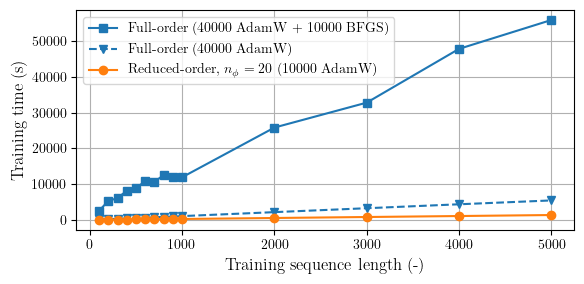

In [15]:
# computational time
plt.figure(figsize=(6,3))
#plt.title("Training time")
plt.plot(ckpt_full["train_lens"], ckpt_full["train_time"], label="Full-order (40000 AdamW + 10000 BFGS)", marker="s", color="C0")
plt.plot(ckpt_full["train_lens"], ckpt_full["train_time_adam"], label="Full-order (40000 AdamW)", marker="v", linestyle="--", color="C0")
plt.plot(ckpt_red_20["train_lens"], ckpt_red_20["train_time"], label=r"Reduced-order, $n_\phi=20$ (10000 AdamW)", marker="o", color="C1")
plt.xlabel("Training sequence length (-)")
plt.ylabel("Training time (s)")
plt.grid(True)
plt.legend();
plt.tight_layout()
plt.savefig(fig_dir/"training_times_paper.pdf")